<a href="https://colab.research.google.com/github/oenereaty/MP2024/blob/main/MP2024_wk5_%EC%88%98%EC%A0%95%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

In [112]:
pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

In [113]:
from datasets import load_dataset

food = load_dataset("food101", split="train[:5000]")

In [114]:
food = food.train_test_split(test_size=0.2)


# 코드정리 1

In [115]:
import datasets
import transformers
import torchvision.transforms
import evaluate
import numpy as np


## Step1
### A. 데이터불러오기
food = datasets.load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)
### B. 전처리하기
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size),
    torchvision.transforms.ToTensor(),
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)
## Step2
### A. 인공지능을 만들기 위한 준비코드
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
### B. 인공지능 모델만들기
model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)
## Step3
### A. 트레이너생성을 위한 준비
data_collator = transformers.DefaultDataCollator()
accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)
training_args = transformers.TrainingArguments(
    output_dir="my_awesome_food_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)
### B. 트레이너 생성
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)
### C. 트레이너를 이용한 학습
trainer.train()
## Step4

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
0,2.642200,2.483752,0.828000
2,1.563200,1.565784,0.900000


TrainOutput(global_step=186, training_loss=2.392751673216461, metrics={'train_runtime': 591.8334, 'train_samples_per_second': 20.276, 'train_steps_per_second': 0.314, 'total_flos': 9.232831524962304e+17, 'train_loss': 2.392751673216461, 'epoch': 2.976})

In [116]:
# Step4
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


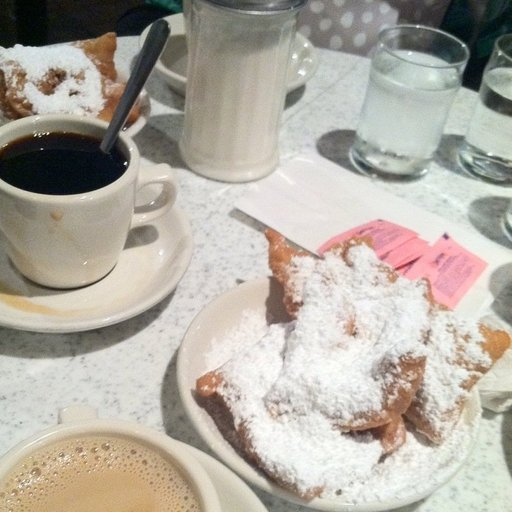

In [117]:
import datasets
import transformers
import torchvision.transforms
import evaluate
import numpy as np

ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
image
# classifier(image)
# image vs. classifier(image)

In [118]:
classifier(image)

[{'label': 'beignets', 'score': 0.9714367389678955},
 {'label': 'chicken_wings', 'score': 0.6107726693153381},
 {'label': 'prime_rib', 'score': 0.6023385524749756},
 {'label': 'hamburger', 'score': 0.5858390927314758},
 {'label': 'ramen', 'score': 0.5835704207420349}]

# 살펴보기

### 데이터 불러오기

In [119]:
food_full = datasets.load_dataset("food101")
food_full
# 자료가 약 10만개(75750+25250), 자료형은 DatasetDict 임

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 75750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

In [120]:
food5000 = datasets.load_dataset("food101", split="train[:5000]")
food5000
# 자료는 5000개, 자료형은 Dataset
#train 중에서 5000개만 추출함

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

In [188]:
food = food5000.train_test_split(test_size=0.2)
food

#얘는 왜 또 DatasetDict야?
#test_size=0.2의 의미: test용으로 20%만 따로 빼놔! -> test의 num_rows의 개수가 1000개

[79, 20, 10, 79, 10]

## 데이터 살펴보기

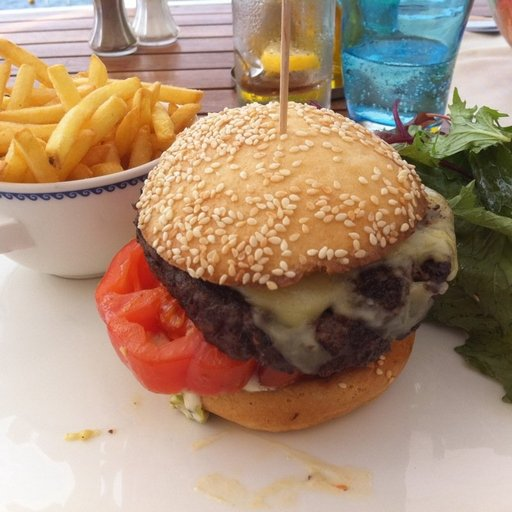

In [122]:
# 이미지 보는 방법

food['train'][0]['image']

In [123]:
# 이미지의 label을 확인하는 방법

food['train'][0]['label']

53

In [124]:
# 라벨 '53'이 의미하는 바는?

labels = food['train'].features['label'].names
# 의 53번째

In [125]:
labels = food['train'].features['label'].names
labels[53]

'hamburger'

In [126]:
food5000
#얘는 'train'랑, 'test'가 독립적으로 존재하지 않네👀

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

In [127]:
food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

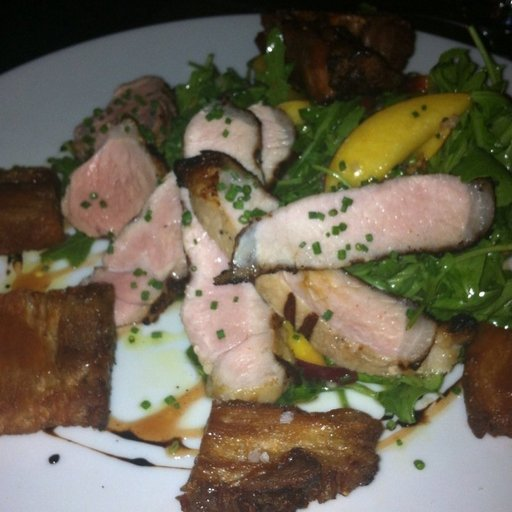

In [128]:
food['train'][25]['image']
# food['train'][255]['label']

In [129]:
labels = food['train'].features['label'].names
labels[25]

'club_sandwich'

In [130]:
# 이미지의 크기 조사하는 방법
# 방법 1

food['train'][0]

# size=512x512

{'image': <PIL.Image.Image image mode=RGB size=512x512>, 'label': 53}

In [131]:
food['train'][6]

# size=384x512

{'image': <PIL.Image.Image image mode=RGB size=384x512>, 'label': 81}

In [132]:
# 방법1
food['train'][3]['image'].__str__().split(' ')[-3].split("=")[-1].split("x")
sizes = [l['image'].__str__().split(' ')[-3].split("=")[-1].split("x") for l in food['train']]
sizes[:4]

[['512', '512'], ['512', '512'], ['512', '512'], ['512', '512']]

In [133]:
# 방법2
sizes = [l['image'].size for l in food['train']]
sizes[:4]

# img의 내장 함수(size) 이용

[(512, 512), (512, 512), (512, 512), (512, 512)]

## torchvision.trasforms (**자르고크기조정하기**)

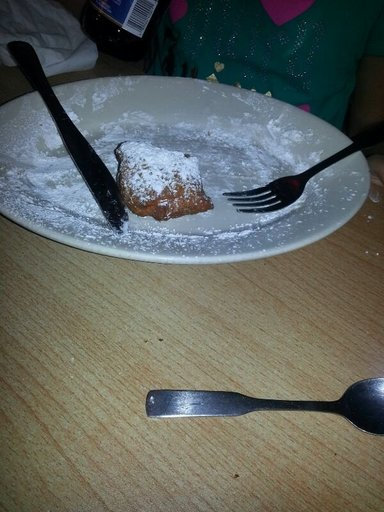

In [134]:
img = datasets.load_dataset("food101",split="train[:1]")[0]['image']
img

In [135]:
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop((224,224))

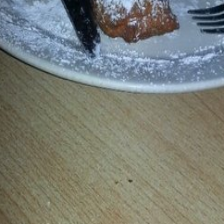

In [136]:
자르고크기조정하기(img)
# '자르고크기조정하기' 함수의 입력값을 통해 사진의 크기를 조절할 수 있음, 숫자 한 개만 입력 시 정사각형 모형.

```Python
자르고크기조정하기 = torchvision.transforms.RandomResizedCrop((224,112))
```
**RandomResizedCrop** 이기 때문에, 사진을 랜덤으로 크롭하게 됨

## torchvision.transform.ToTensor() (**텐서화하기**)

In [137]:
텐서화하기 = torchvision.transforms.ToTensor()

In [138]:
dir(텐서화하기)
# callable 함수 -> 입력값 要

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

In [139]:
텐서화하기(img).shape

# (3, 512, 384)
# 512와 384는 이미지의 크기
# 3은 RGB의 채널

torch.Size([3, 512, 384])

In [140]:
# 텐서화하기(자르고크기조정하기) 와, 자르고크기조정하기(텐서화하기) 의 결과는 동일함

## torchvision.transform.Nomalize (**표준화하기**)

In [141]:
표준화하기 = torchvision.transforms.Normalize(mean=[10,20,30],std=[0.5,1.0,1.5])

In [142]:
표준화하기(텐서화하기(img))
# 숫자들이 계산됨

tensor([[[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
         ...,
         [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2392, -19.2157],
         [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
         [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]],

        [[-19.8627, -19.8706, -19.8745,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8588, -19.8627, -19.8667,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8549, -19.8588, -19.8588,  ..., -19.8980, -19.9020, -19.9020],
         ...,
         [-19.7529, -19.7373, -19.7255,  ..., -19.6353, -19.6235, -19.6118],
         [-19.7765, -19.7647, -19.7451,  ..., -19.6745, -19.6667, -19.6667],
         [-19.7882, -19.7843, -19.7647,  ..., -19.6784, -19.6863, -19.6980]],

        [[-19.9059, -19.9111, -19.9085,  ...

In [143]:
(텐서화하기(img)[0]-10)/0.5

tensor([[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
        [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
        [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
        ...,
        [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2392, -19.2157],
        [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
        [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]])

In [144]:
표준화하기(텐서화하기(img))

tensor([[[-19.7569, -19.7725, -19.7804,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7490, -19.7569, -19.7647,  ..., -19.9922, -19.9922, -20.0000],
         [-19.7412, -19.7490, -19.7490,  ..., -19.9922, -20.0000, -20.0000],
         ...,
         [-19.4824, -19.4510, -19.4275,  ..., -19.2471, -19.2392, -19.2157],
         [-19.5294, -19.5059, -19.4667,  ..., -19.3255, -19.3255, -19.3255],
         [-19.5529, -19.5451, -19.5059,  ..., -19.3333, -19.3647, -19.3882]],

        [[-19.8627, -19.8706, -19.8745,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8588, -19.8627, -19.8667,  ..., -19.8980, -19.8980, -19.9020],
         [-19.8549, -19.8588, -19.8588,  ..., -19.8980, -19.9020, -19.9020],
         ...,
         [-19.7529, -19.7373, -19.7255,  ..., -19.6353, -19.6235, -19.6118],
         [-19.7765, -19.7647, -19.7451,  ..., -19.6745, -19.6667, -19.6667],
         [-19.7882, -19.7843, -19.7647,  ..., -19.6784, -19.6863, -19.6980]],

        [[-19.9059, -19.9111, -19.9085,  ...

In [145]:
# 똑같다!

```Python
(텐서화하기(img)[0]-10)/0.5
```
[0]-10... 부분이
```Python
표준화하기 = torchvision.transforms.Normalize(mean=[10,20,30],std=[0.5,1.0,1.5])
```
(mean=[10...)에 대응

In [146]:
텐서화하기(img)[0] # R
텐서화하기(img)[1] # G
텐서화하기(img)[2] # B

tensor([[0.1412, 0.1333, 0.1373,  ..., 0.0902, 0.0902, 0.0863],
        [0.1451, 0.1412, 0.1451,  ..., 0.0902, 0.0902, 0.0863],
        [0.1569, 0.1529, 0.1529,  ..., 0.0902, 0.0863, 0.0863],
        ...,
        [0.1725, 0.1882, 0.2000,  ..., 0.2431, 0.2549, 0.2667],
        [0.1490, 0.1608, 0.1804,  ..., 0.2039, 0.2118, 0.2118],
        [0.1373, 0.1412, 0.1608,  ..., 0.2000, 0.1922, 0.1804]])

`표준화하기`는 각 채널별로, `mean`을 뺀 뒤, `std`를 나눈 계산값을 return함

## torchvision.transforms.Compose (**여러 함수 묶기**)

<이미지 가공 순서>

자르고크기조정하기$\to$텐서화하기$\to$표준화하기

In [147]:
표준화하기(텐서화하기(자르고크기조정하기(img)))

# 이런 방식이 비효율적임

tensor([[[-19.2627, -19.2863, -19.2549,  ..., -19.6706, -19.8510, -19.9373],
         [-19.2471, -19.2627, -19.2784,  ..., -19.3804, -19.5294, -19.6863],
         [-19.2627, -19.2941, -19.2549,  ..., -19.2863, -19.3412, -19.3961],
         ...,
         [-19.2078, -19.2392, -19.2627,  ..., -19.0431, -19.0510, -19.0118],
         [-19.2314, -19.2627, -19.2627,  ..., -18.9882, -19.0353, -19.0431],
         [-19.2784, -19.2549, -19.2549,  ..., -19.0745, -19.0510, -19.0275]],

        [[-19.5922, -19.6039, -19.5882,  ..., -19.7412, -19.8196, -19.8627],
         [-19.5804, -19.5882, -19.5922,  ..., -19.6118, -19.6784, -19.7529],
         [-19.5882, -19.5961, -19.5765,  ..., -19.5765, -19.5961, -19.6196],
         ...,
         [-19.6157, -19.6314, -19.6431,  ..., -19.5490, -19.5490, -19.5294],
         [-19.6275, -19.6392, -19.6392,  ..., -19.5176, -19.5373, -19.5412],
         [-19.6549, -19.6353, -19.6392,  ..., -19.5647, -19.5490, -19.5373]],

        [[-19.7098, -19.7124, -19.7020,  ...

In [148]:
이미지처리하기 = torchvision.transforms.Compose([자르고크기조정하기, 텐서화하기, 표준화하기])

In [149]:
dir(이미지처리하기)

# 이미지처리하기 함수는 callable function

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'transforms']

In [150]:
이미지처리하기(img)

tensor([[[-19.4118, -19.4588, -19.4902,  ..., -19.9922, -19.9922, -20.0000],
         [-19.4039, -19.4353, -19.4667,  ..., -19.9922, -19.9922, -20.0000],
         [-19.4039, -19.4431, -19.4431,  ..., -20.0000, -20.0000, -20.0000],
         ...,
         [-19.1373, -19.1529, -19.1922,  ..., -18.9961, -18.9333, -18.8706],
         [-19.2000, -19.1373, -19.1216,  ..., -19.0196, -19.0510, -19.0275],
         [-19.1294, -19.1843, -19.0980,  ..., -18.9412, -19.0118, -19.0431]],

        [[-19.6706, -19.6863, -19.6941,  ..., -19.8431, -19.8431, -19.8471],
         [-19.6667, -19.6784, -19.6902,  ..., -19.8431, -19.8431, -19.8471],
         [-19.6706, -19.6863, -19.6824,  ..., -19.8471, -19.8471, -19.8471],
         ...,
         [-19.5961, -19.6039, -19.6157,  ..., -19.5373, -19.5098, -19.4784],
         [-19.6353, -19.6000, -19.5843,  ..., -19.5490, -19.5686, -19.5569],
         [-19.6078, -19.6275, -19.5804,  ..., -19.5137, -19.5490, -19.5647]],

        [[-19.7542, -19.7647, -19.7725,  ...

# 이미지전처리

In [151]:
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size),
    torchvision.transforms.ToTensor(),
    normalize
])
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food = food.with_transform(transforms)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


```Python
normalize = torchvision.transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
  ```


에서

`mean`은 각각 `[0.5, 0.5, 0.5]`가 되며, `std`은 각각 `[0.5, 0.5, 0.5]`가 됨.

(※ `image_processor` 를 출력해보면 알 수 있음.)

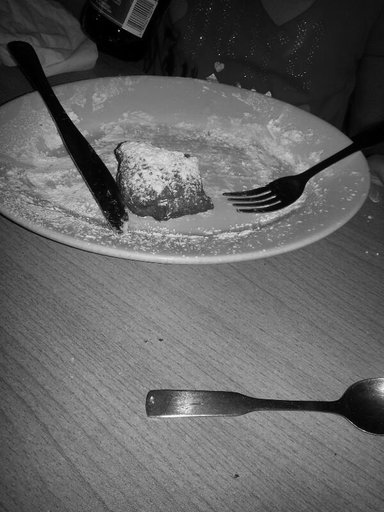

In [152]:
img.convert("L")

# 흑백

## image_precessor




In [153]:
image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

## size

In [154]:
size = image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size else (image_processor.size["height"], image_processor.size["width"])

In [155]:
size

# (224, 224) 가 의미하는 것은 무엇일까?

(224, 224)

```python
size = image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size else (image_processor.size["height"], image_processor.size["width"])
```

1. 만약 `image_processor.size`에 `shortest_edge(제일 작은 사진 크기)`가 **있다면** $\to$ 그 값을 `size`로 지정함
2.  만약 `image_processor.size`에 `shortest_edge(제일 작은 사진 크기)`가 **없다면** $\to$ `[height]`와 `[width]` 값을 사용하여 `([height], [width])`의 튜플로 저장함

## transforms(example)

```Python
food = datasets.load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)
```
라는 것을 다시 알려주고, 이후 `food_transformed`라는 함수를 불러와야 함.

만약에 `food_transformed`라는 함수를 먼저 정의하고, `food`데이터 값을 재정의한다면, 내가 앞서 이미 부른 `food`에 대해서 `tranformed`함수를 먼저 실행 $\to$ 새로운 `food` 값으로 `food['train'][사용자가원하는구간]['label']`을 실행할 것임.

In [215]:
food = datasets.load_dataset("food101", split="train[:5000]")
food = food.train_test_split(test_size=0.2)
food['train'][0:5]['label']

[6, 10, 81, 20, 6]

In [216]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food_transformed = food.with_transform(transforms)

```python
def "transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples
food_transformed = food.with_transform(transforms)
```

1. ("L")일 수도 있으니, convert("RGB") 하여라. 이때 사용되는 함수는 _transforms
2. 변환되기 이전의 원본은 `del`하여 메모리 확

In [217]:
food_transformed['train'][0:5]['label']

[6, 10, 81, 20, 6]

In [218]:
food_transformed['train'][0:5]['label']

[6, 10, 81, 20, 6]

In [219]:
food['train'][0:5]['label']

[6, 10, 81, 20, 6]

In [197]:
examples = food['train'][0:5]
transforms(examples)

{'label': [10, 81, 6, 79, 20],
 'pixel_values': [tensor([[[-0.0745,  0.0824,  0.1451,  ...,  0.0667,  0.0667,  0.1137],
           [ 0.0745,  0.1451,  0.1765,  ...,  0.0431,  0.0980,  0.1059],
           [ 0.1294,  0.1843,  0.2000,  ...,  0.0353,  0.0667,  0.0353],
           ...,
           [ 0.4510,  0.4667,  0.4824,  ..., -0.0902, -0.0275,  0.0902],
           [ 0.4588,  0.4745,  0.4824,  ...,  0.2784,  0.0275, -0.0510],
           [ 0.4745,  0.4588,  0.4667,  ...,  0.6157,  0.5216,  0.3020]],
  
          [[-0.1843, -0.0118,  0.0667,  ..., -0.0980, -0.0980, -0.0510],
           [-0.0275,  0.0588,  0.1059,  ..., -0.1137, -0.0588, -0.0510],
           [ 0.0510,  0.1059,  0.1294,  ..., -0.1137, -0.0745, -0.1059],
           ...,
           [ 0.4039,  0.4118,  0.4196,  ..., -0.2314, -0.1765, -0.0824],
           [ 0.4118,  0.4039,  0.4118,  ...,  0.1608, -0.1059, -0.2157],
           [ 0.4039,  0.3882,  0.3882,  ...,  0.5137,  0.3961,  0.1529]],
  
          [[-0.2706, -0.0745,  0.0353

In [205]:
food_transformed['train'][0:5]['label']

[79, 20, 10, 79, 10]

In [207]:
ssibal = food['train'][0:5]['label']
# transforms(ssibal)
ssibal

[10, 81, 6, 79, 20]

```python
food_transformed = food.with_transform(transforms)
```
`-` 지연 코드

In [250]:
examples = food['train'][0:5]

In [251]:
examples
# 1st, 자세하게

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
  <PIL.Image.Image image mode=RGB size=512x289>,
  <PIL.Image.Image image mode=RGB size=512x512>,
  <PIL.Image.Image image mode=RGB size=382x512>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>],
 'label': [6, 10, 81, 20, 6]}

In [252]:
transforms(examples)
# 2nd
# food_transformed['train'][0:5] 와 동일한 결괏값

{'label': [6, 10, 81, 20, 6],
 'pixel_values': [tensor([[[-0.0902, -0.4902, -0.6157,  ...,  0.5765,  0.5765,  0.5765],
           [-0.0588, -0.4196, -0.5608,  ...,  0.6078,  0.6078,  0.6157],
           [-0.0745, -0.3725, -0.5137,  ...,  0.6392,  0.6392,  0.6549],
           ...,
           [ 0.1451,  0.1608,  0.1843,  ..., -0.0745, -0.0824, -0.0980],
           [ 0.1529,  0.1608,  0.1765,  ..., -0.1451, -0.1608, -0.1686],
           [ 0.1529,  0.1608,  0.1686,  ..., -0.2078, -0.2392, -0.2392]],
  
          [[-0.2314, -0.6471, -0.8118,  ...,  0.4353,  0.4431,  0.4510],
           [-0.2235, -0.6000, -0.7725,  ...,  0.4667,  0.4824,  0.4902],
           [-0.2627, -0.5922, -0.7333,  ...,  0.5059,  0.5137,  0.5294],
           ...,
           [-0.0667, -0.0431, -0.0275,  ..., -0.2627, -0.2627, -0.2784],
           [-0.0667, -0.0588, -0.0510,  ..., -0.3490, -0.3647, -0.3647],
           [-0.0824, -0.0667, -0.0745,  ..., -0.4196, -0.4588, -0.4588]],
  
          [[-0.3647, -0.7412, -0.8667,

# 모델생성

## 인공지능을 만들기 위한 준비코드

In [224]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [225]:
food['train'].features['label']

ClassLabel(names=['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'mac

In [226]:
# label2id, id2label
# 라벨과 메뉴 間 매핑

In [227]:
labels = food["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [228]:
# labels

In [229]:
모델생성하기 = model = transformers.AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [230]:
model(이미지처리하기(img))

# 실행이 안 돼!
# 인공지능은 **여러 장**의 이미지(배치형태)를 입력값으로 받을 것을 예상하기 때문.
# 만약 한 장이라면 reshape를 해줘야 함

ValueError: not enough values to unpack (expected 4, got 3)

In [231]:
이미지처리하기(img).shape

# 이미지처리하기 = torchvision.transforms.Compose([자르고크기조정하기, 텐서화하기, 표준화하기])
# food = food.with_transform(transforms)
# "이미지처리하기" 함수는 자르고, 텐서화하고, 표준화하고, 흑백이면 컬러로 바꾸고, 바꾸기 이전 사진은 del하고!
# 까지의 과정을 거침

torch.Size([3, 224, 224])

In [232]:
이미지처리하기(img).reshape(1,3,224,224)

tensor([[[[-19.9765, -19.9294, -19.8196,  ..., -19.9059, -19.8980, -19.8902],
          [-19.9922, -19.9765, -19.7490,  ..., -19.9059, -19.8980, -19.8980],
          [-19.9843, -19.9922, -19.8902,  ..., -19.8980, -19.8980, -19.8980],
          ...,
          [-19.1843, -19.1765, -19.2235,  ..., -19.2157, -19.1137, -19.1137],
          [-19.2627, -19.1608, -19.1137,  ..., -19.2314, -19.2157, -19.2000],
          [-19.2157, -19.2235, -19.1373,  ..., -19.1373, -19.1686, -19.2235]],

         [[-19.9725, -19.9451, -19.8863,  ..., -19.9451, -19.9451, -19.9373],
          [-19.9804, -19.9647, -19.8431,  ..., -19.9490, -19.9451, -19.9373],
          [-19.9725, -19.9765, -19.9176,  ..., -19.9451, -19.9412, -19.9333],
          ...,
          [-19.5961, -19.5882, -19.6118,  ..., -19.6353, -19.5843, -19.5843],
          [-19.6314, -19.5765, -19.5569,  ..., -19.6431, -19.6353, -19.6275],
          [-19.6118, -19.6078, -19.5725,  ..., -19.5961, -19.6118, -19.6392]],

         [[-19.9817, -19.9634,

```python
이미지처리하기(img).reshape(1,3,224,224)
```

이런 식으로 수정해줘야 한다.

여기서,`.reshape`의 괄호 안 숫자들의 의미는

.reshape(1=이미지개수, 3=차원의개수, 224&224=이미지의크기)


`.reshape`의 과정을 **데이터콜렉터**가 수행함

# 데이터콜렉터

`-` 데이터콜렉터 생성
- 텍스트형에서 사용할 때는 자료형을 파이토치 텐서형으로 바꿔주기도 하고, 동적 패딩을 사용하여 적절한 길이로 잘라주기/채워주기도 하고, 여러 개씩 묶어 배치형태로 만들어 주기도 하였음
- 하지만 이미 resize, 텐서화를 끝냈으므로 이미지형에서는 데이터콜렉터의 비중이 크지 않음$\to$ 미니배치의 기능만 수행하는 정도
- `Dict,Dict,Dict...`의 꼴이었음


In [233]:
 data_collator = transformers.DefaultDataCollator()

In [234]:
# food_transformed['train'][:2]['pixel_values'].shape    <<<<<< 오류

# 지금 이미지끼리 tensor가 따로(?) 존재함
# .reshape의 과정을 아직 거치지 못 하여 model에 넣지 못 함

In [235]:
import torch
torch.stack(food_transformed['train'][:2]['pixel_values'],axis=0).shape

# 수동으로 한번 해보자!
# 결과) resize가 실행됨

torch.Size([2, 3, 224, 224])

In [236]:
data_collator([food_transformed['train'][0],food_transformed['train'][1]])['pixel_values'].shape

# 결과) resize가 실행됨

torch.Size([2, 3, 224, 224])

# 추론

In [237]:
# Step4
classifier = transformers.pipeline("image-classification", model="my_awesome_food_model/checkpoint-186")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [238]:
ds = datasets.load_dataset("food101", split="validation[:10]")
image = ds["image"][0]
classifier(image)

[{'label': 'beignets', 'score': 0.9714367389678955},
 {'label': 'chicken_wings', 'score': 0.6107726693153381},
 {'label': 'prime_rib', 'score': 0.6023385524749756},
 {'label': 'hamburger', 'score': 0.5858390927314758},
 {'label': 'ramen', 'score': 0.5835704207420349}]

In [239]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

Q. 타입이 `JpegImageFile`인 이미지 파일을 전달하면 `classifier`가 알아서 구별해주지 않을까...?

In [240]:
# from PIL import Image
# import requests
# from io import BytesIO

# # 이미지 URL
# url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Shoyu_ramen%2C_at_Kasukabe_Station_%282014.05.05%29_1.jpg/500px-Shoyu_ramen%2C_at_Kasukabe_Station_%282014.05.05%29_1.jpg"

# # URL에서 이미지 불러오기
# response = requests.get(url)
# image = Image.open(BytesIO(response.content))
# image

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7a8829121710>

In [241]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [242]:
classifier(image)

[{'label': 'beignets', 'score': 0.9714367389678955},
 {'label': 'chicken_wings', 'score': 0.6107726693153381},
 {'label': 'prime_rib', 'score': 0.6023385524749756},
 {'label': 'hamburger', 'score': 0.5858390927314758},
 {'label': 'ramen', 'score': 0.5835704207420349}]

# 코드정리 2

In [ ]:
# ## Step1
# food = datasets.load_dataset("food101", split="train[:5000]").train_test_split(test_size=0.2)
# image_processor = transformers.AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# def transforms(examples):
#     _transforms = torchvision.transforms.Compose([
#         torchvision.transforms.RandomResizedCrop(224),
#         torchvision.transforms.ToTensor(),
#         torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
#     ])
#     examples["pixel_values"] = [_transforms(img) for img in examples["image"]]
#     del examples["image"]
#     return examples
# food = food.with_transform(transforms)
# ## Step2
# labels = food["train"].features["label"].names
# label2id, id2label = dict(), dict()
# for i, label in enumerate(labels):
#     label2id[label] = i
#     id2label[i] = label
# model = transformers.AutoModelForImageClassification.from_pretrained(
#     "google/vit-base-patch16-224-in21k",
#     num_labels=len(labels),
#     id2label=id2label,
#     label2id=label2id,
# )
# ## Step3
# data_collator = transformers.DefaultDataCollator()
# accuracy = evaluate.load("accuracy")
# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     return accuracy.compute(predictions=predictions, references=labels)
# training_args = transformers.TrainingArguments(
#     output_dir="my_awesome_food_model",
#     remove_unused_columns=False,
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=5e-5,
#     per_device_train_batch_size=16,
#     gradient_accumulation_steps=4,
#     per_device_eval_batch_size=16,
#     num_train_epochs=4,
#     warmup_ratio=0.1,
#     logging_steps=10,
#     load_best_model_at_end=True,
#     metric_for_best_model="accuracy",
#     push_to_hub=False,
#     report_to="none"
# )
# trainer = transformers.Trainer(
#     model=model,
#     args=training_args,
#     data_collator=data_collator,
#     train_dataset=food["train"],
#     eval_dataset=food["test"],
#     tokenizer=image_processor,
#     compute_metrics=compute_metrics,
# )
# trainer.train()
# ## Step4